# Project Unsupervised Learning
# Andres Delgadillo

## 1 Project: AllLife Bank Customer Segmentation

### 1.1 Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

### 1.2 Data Dictionary


- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)


### 1.3 Questions to be answered
- In how many groups the bank can classify the customers?
- What are the main characteristics of different groups of customers?

## 2 Import packages and turnoff warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
import time
sns.set(color_codes=True)
%matplotlib inline

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

## 3 Import dataset and quality of data

In [2]:
# read data from excel file
data = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
# get columns
data.columns

Index(['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [4]:
# get size of dataset
data.shape

(660, 7)

In [5]:
# check dataset information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [6]:
# check dataset missing values
total = data.isnull().sum().sort_values(ascending=False) # total number of null values
print(total)

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64


In [7]:
# check for duplicates
data.duplicated().sum()

0

This first assessment of the dataset shows:
- There are 660 rows and 7 features
- There is no missing data
- There are not duplicated rows

## 4 Exploratory Data Analysis

In [8]:
# check first rows of data
data.head()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
1                  0                   10                 9  
2                  1                    3                 4  
3                  1                    1                 4  
4                  0                   12                 3

In [9]:
# check last rows of data
data.tail()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
655    656         51108             99000                  10   
656    657         60732             84000                  10   
657    658         53834            145000                   8   
658    659         80655            172000                  10   
659    660         80150            167000                   9   

     Total_visits_bank  Total_visits_online  Total_calls_made  
655                  1                   10                 0  
656                  1                   13                 2  
657                  1                    9                 1  
658                  1                   15                 0  
659                  0                   12                 2

### 4.1 Pandas profiling report
We can get a first statistical and descriptive analysis using pandas_profiling

In [10]:
# get pandas profiling report
pandas_profiling.ProfileReport(data)

Pandas Profiling report is showing some warnings/characteristics in the data:
- Sl_No is uniformly distributed, and all rows are unique values has unique values
- Customer Key has 665 distinct values. That means there are some customers with multiple data
- Total_visits_bank, Total_visits_online, and Total_calls_made have values with zeros

### 4.2 Univariate Analysis

In [11]:
# get stats for the columns
data.describe().T

count          mean           std      min       25%  \
Sl_No                660.0    330.500000    190.669872      1.0    165.75   
Customer Key         660.0  55141.443939  25627.772200  11265.0  33825.25   
Avg_Credit_Limit     660.0  34574.242424  37625.487804   3000.0  10000.00   
Total_Credit_Cards   660.0      4.706061      2.167835      1.0      3.00   
Total_visits_bank    660.0      2.403030      1.631813      0.0      1.00   
Total_visits_online  660.0      2.606061      2.935724      0.0      1.00   
Total_calls_made     660.0      3.583333      2.865317      0.0      1.00   

                         50%       75%       max  
Sl_No                  330.5    495.25     660.0  
Customer Key         53874.5  77202.50   99843.0  
Avg_Credit_Limit     18000.0  48000.00  200000.0  
Total_Credit_Cards       5.0      6.00      10.0  
Total_visits_bank        2.0      4.00       5.0  
Total_visits_online      2.0      4.00      15.0  
Total_calls_made         3.0      5.00      10.0

- **Avg_Credit_Limit**
    - Average credit limit is between 3000 and 200000
    - Mean is 34574.2 and median 18000
    - Distribution is skewed
- **Total_Credit_Cards**
    - Total number of credit cards is between 1 and 10
    - Mean is 4.7 and median is 5
- **Total_visits_bank**
    - Total number of visits is between 0 and 5
    - Mean is 2.4 and median is 2  
- **Total_visits_online**
    - Total number of visits online is between 0 and 15
    - Mean is 2.6 and median is 2
- **Total_calls_made**
    - Total number of calls made is between 0 and 10
    - Mean is 3.6 and median is 3

###  4.3 Pairplot.
We are going to perform bivariate analysis to understand the relationship between the columns

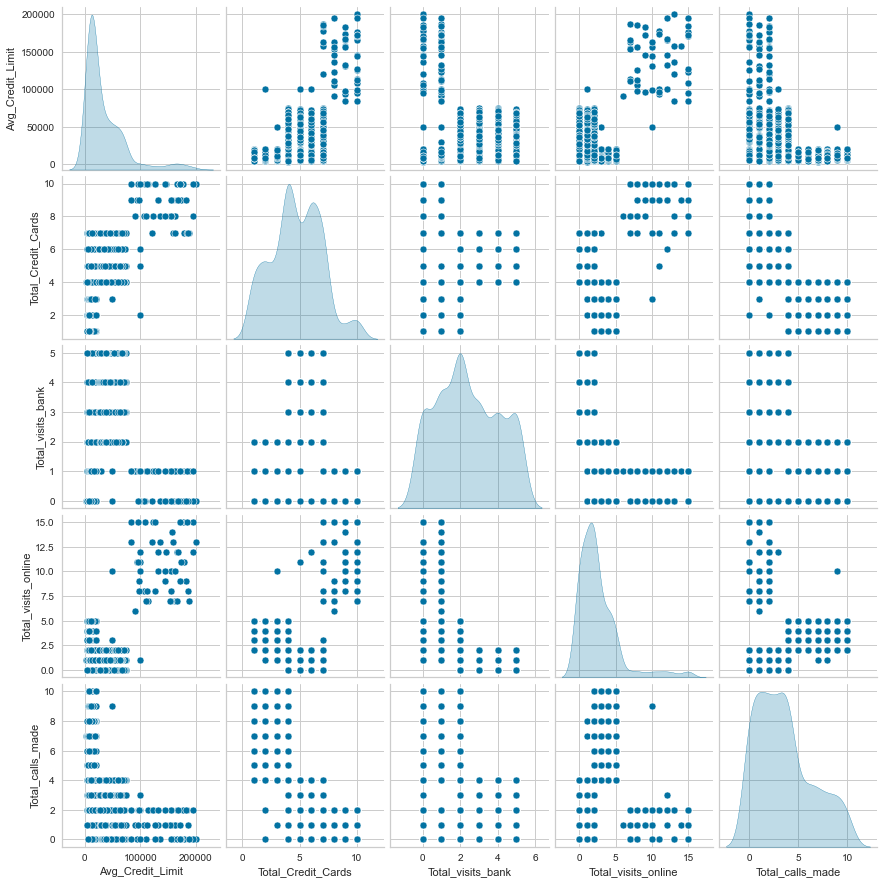

In [12]:
# Continuous columns
con_col = ['Avg_Credit_Limit', 'Total_Credit_Cards','Total_visits_bank', 
           'Total_visits_online', 'Total_calls_made']
# Pairplot for continuous columns
sns.pairplot(data[con_col], diag_kind='kde');

### 4.4 Bivariate and Multivariate Analysis

In [13]:
# Get correlation matrix for numeric variables
data[con_col].corr()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Avg_Credit_Limit             1.000000            0.608860          -0.100312   
Total_Credit_Cards           0.608860            1.000000           0.315796   
Total_visits_bank           -0.100312            0.315796           1.000000   
Total_visits_online          0.551385            0.167758          -0.551861   
Total_calls_made            -0.414352           -0.651251          -0.506016   

                     Total_visits_online  Total_calls_made  
Avg_Credit_Limit                0.551385         -0.414352  
Total_Credit_Cards              0.167758         -0.651251  
Total_visits_bank              -0.551861         -0.506016  
Total_visits_online             1.000000          0.127299  
Total_calls_made                0.127299          1.000000

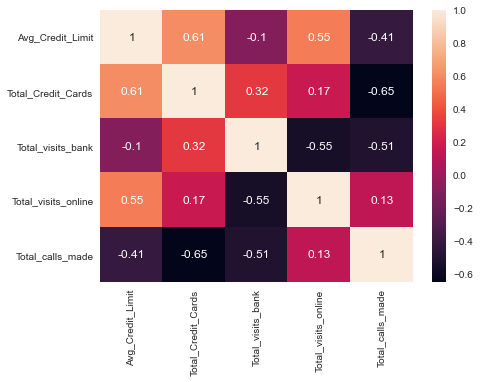

In [14]:
# Display correlation matrix in a heatmap
fig, ax = plt.subplots(figsize=(7,5)) 
sns.heatmap(data[con_col].corr(), annot=True, ax=ax);

Features with positive correlation:
- Avg_Credit_Limit and Total_Credit_Cards have 0.61 correlation
- Avg_Credit_Limit and Total_visits_online have 0.55 correlation 

Features with negative correlation
- Avg_Credit_Limit and Total_calls_made have -0.41 correlation
- Total_Credit_Cards and Total_calls_made have -0.65 correlation
- Total_visits_bank and Total_visits_online have -0.51 correlation
- Total_visits_bank and Total_calls_made have -0.51 correlation

## 5 Data Pre-Processing

### 5.1 Feature Engineering
- Drop Sl_No column
- Investigate duplicate rows for Customer Key

In [15]:
# Drop CustomerID column
data.drop(['Sl_No'], axis=1, inplace=True)

In [16]:
# Duplicated rows in Customer Key
data[data['Customer Key'].duplicated(keep=False)].sort_values(by=['Customer Key'])

Customer Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
48          37252              6000                   4                  0   
432         37252             59000                   6                  2   
4           47437            100000                   6                  0   
332         47437             17000                   7                  3   
411         50706             44000                   4                  5   
541         50706             60000                   7                  5   
391         96929             13000                   4                  5   
398         96929             67000                   6                  2   
104         97935             17000                   2                  1   
632         97935            187000                   7                  1   

     Total_visits_online  Total_calls_made  
48                     2                 8  
432                    1                 2  
4                     12                 3  
332                    1                 0  
411                    0                 2  
541                    2                 2  
391                    0                 0  
398                    2                 2  
104                    2                10  
632                    7                 0

- There are 5 customers (37252, 47437, 50706, 96929, 97935) with duplicated information. The duplicate values might correspond to customer profile changes, and as such, there is no need to delete these records as these are actual occurrences at some point in the time
- We are going to keep all records since we do not have more information about the data gathering process

In [17]:
# Drop Customer Key column
data.drop(['Customer Key'], axis=1, inplace=True)

### 5.2 Outliers detection
We are going to analyze if there are outliers in the features

In [18]:
# This function create a plot with the boxplot and distribution of the series
def histboxplot(feature):
    # creating the 2 subplots
    f2, (ax_box1, ax_hist1) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           ncols = 1, # Number of Columns of the subplot grid= 1
                                           sharex = 'col', # x-axis will be shared among columns
                                           figsize = (7,6),
                                           gridspec_kw = {"height_ratios": (.25, .75)});
    sns.boxplot(feature, ax=ax_box1, showmeans=True, color='violet'); # boxplot 
    sns.distplot(feature, kde=True, ax=ax_hist1); # histogram
    ax_hist1.axvline(np.mean(feature), color='green', linestyle='--'); # Add mean to the histogram
    ax_hist1.axvline(np.median(feature), color='black', linestyle='-');

**Avg_Credit_Limit**

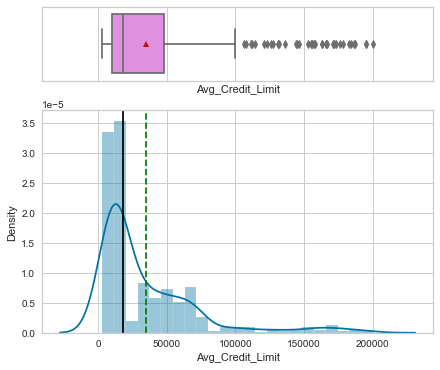

In [19]:
# display histbox 
histboxplot(data['Avg_Credit_Limit'])

There are several points with average credit limit above the upper whisker 100000. However, those values could correspond to premium customers. Therefore, we are not going to clip those values

**Total_Credit_Cards**

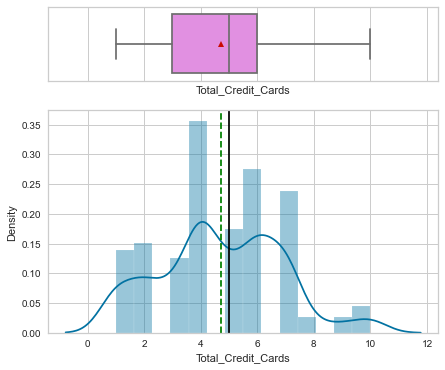

In [20]:
# display histbox 
histboxplot(data['Total_Credit_Cards'])

There are not outliers

**Total_visits_bank**

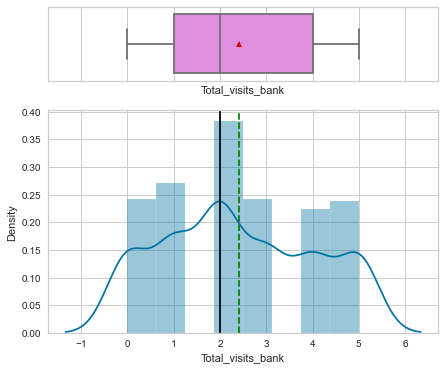

In [21]:
# display histbox 
histboxplot(data['Total_visits_bank'])

There are not outliers

**Total_visits_online**

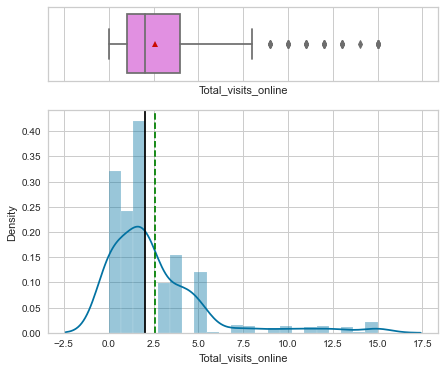

In [22]:
# display histbox 
histboxplot(data['Total_visits_online'])

There are some points above the upper whisker. However, they could correspond to consumers that login more times online. Therefore, we are not going to clip those values

**Total_calls_made**

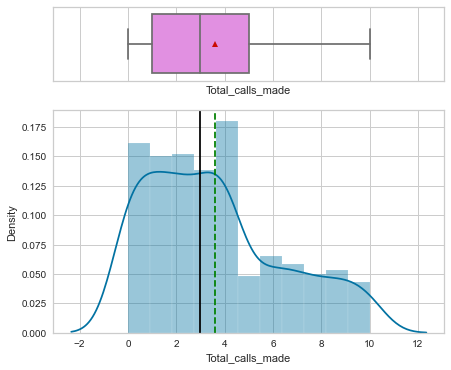

In [23]:
# display histbox 
histboxplot(data['Total_calls_made'])

There are not outliers

### 5.3 Scaling data

In [24]:
# Scaling the data set before clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
# Creating a dataframe from the scaled data
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
data_scaled_df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            1.740187           -1.249225          -0.860451   
1            0.410293           -0.787585          -1.473731   
2            0.410293            1.058973          -0.860451   
3           -0.121665            0.135694          -0.860451   
4            1.740187            0.597334          -1.473731   
..                ...                 ...                ...   
655          1.713589            2.443892          -0.860451   
656          1.314621            2.443892          -0.860451   
657          2.937092            1.520613          -0.860451   
658          3.655235            2.443892          -0.860451   
659          3.522245            1.982253          -1.473731   

     Total_visits_online  Total_calls_made  
0              -0.547490         -1.251537  
1               2.520519          1.891859  
2               0.134290          0.145528  
3              -0.547490          0.145528  
4               3.202298         -0.203739  
..                   ...               ...  
655             2.520519         -1.251537  
656             3.543188         -0.553005  
657             2.179629         -0.902271  
658             4.224968         -1.251537  
659             3.202298         -0.553005  

[660 rows x 5 columns]

## 6 K-means Clustering

### 6.1 Elbow curve
We are going to use the Elbow Curve method to identify the optimal number of clusters

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9426543606899347
Number of Clusters: 7 	Average Distortion: 0.9095950026993534
Number of Clusters: 8 	Average Distortion: 0.8902998903180782


--- Execution time 0.4954409599304199 seconds ---


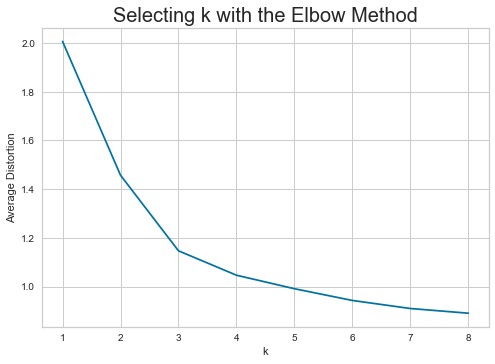

In [25]:
# start time
start_time = time.time()

# set of different number of clusters (K)
clusters = range(1, 9)
# list with distortions
meanDistortions = []

# loop in clusters
for k in clusters:
    # create and fit KMeans model for k
    model = KMeans(n_clusters=k)
    model.fit(data_scaled_df)
    # predict cluster for each row
    prediction = model.predict(data_scaled_df)
    # calculate average distortion using euclidean distance
    distortion = (
        sum(
            np.min(cdist(data_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / data_scaled_df.shape[0]
    )
    # append average distortion
    meanDistortions.append(distortion)
    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

# plot elbow curve    
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

print("\n\n--- Execution time %s seconds ---" % (time.time() - start_time))

- The appropriate value of k from the elbow curve seems to be 3

### 6.2 Silhouette Score
Now, we are going to use the Silhouette Score to identify the optimal number of clusters

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2726898791817692
For n_clusters = 6, silhouette score is 0.2553892519918698
For n_clusters = 7, silhouette score is 0.24865851948404674
For n_clusters = 8, silhouette score is 0.22708508639891067
For n_clusters = 9, silhouette score is 0.21144805721637253


--- Execution time 0.3671855926513672 seconds ---


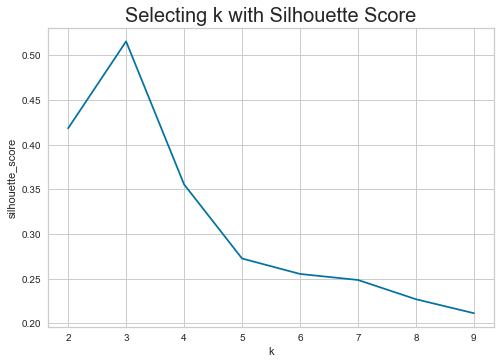

In [26]:
# start time
start_time = time.time()

# set of different number of clusters (K)
clusters = range(2, 10)
# list with silhouette scores
sil_score = []

# loop in clusters
for k in clusters:
    # create and fit KMeans model for k
    model = KMeans(n_clusters=k)
    preds = model.fit_predict((data_scaled_df))
    # calculate silhouette_score
    score = silhouette_score(data_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(k, score))

# plot silhouette_score   
plt.plot(clusters, sil_score, "bx-")
plt.xlabel("k")
plt.ylabel("silhouette_score")
plt.title("Selecting k with Silhouette Score", fontsize=20)


print("\n\n--- Execution time %s seconds ---" % (time.time() - start_time))

- From the silhouette scores, it seems that 3 is a good value of k

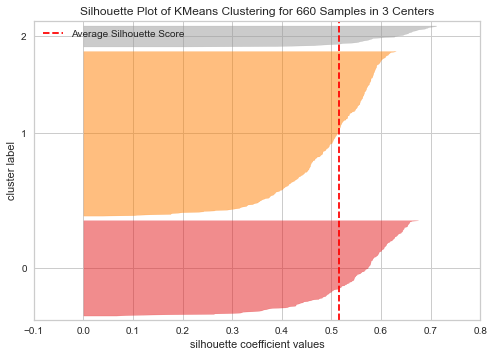



--- Execution time 0.2004995346069336 seconds ---


In [27]:
# start time
start_time = time.time()

# Clusters with silhouette coefficients for K=3
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(data_scaled_df)
visualizer.show();

print("\n\n--- Execution time %s seconds ---" % (time.time() - start_time))

- From the Silhouette Plot we can see that the silhouette coefficients values for the 3 groups are high. Therefore, 3 clusters is an optimal value

### 6.3 Customer profile K=3
K=3 is an appropriate number for clusters because it has the highest silhouette score and there is knick at 3 in the elbow curve

In [28]:
# start time
start_time = time.time()

# create and fit Kmeans model
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_scaled_df)

print("\n\n--- Execution time %s seconds ---" % (time.time() - start_time))



--- Execution time 0.01558995246887207 seconds ---


**Average values for each feature**

In [29]:
# adding kmeans cluster labels to the original dataframe
data['K_means_cluster'] = kmeans.labels_
# create cluster profile
cluster_profile_kmeans = data.groupby('K_means_cluster').mean()
# number of rows in each cluster
cluster_profile_kmeans['Count'] = (data.groupby('K_means_cluster')['Avg_Credit_Limit'].count().values)

In [30]:
# let's display cluster profiles
cluster_profile_kmeans.style.highlight_max(color="lightgreen", axis=0)

**Box plots for each feature**

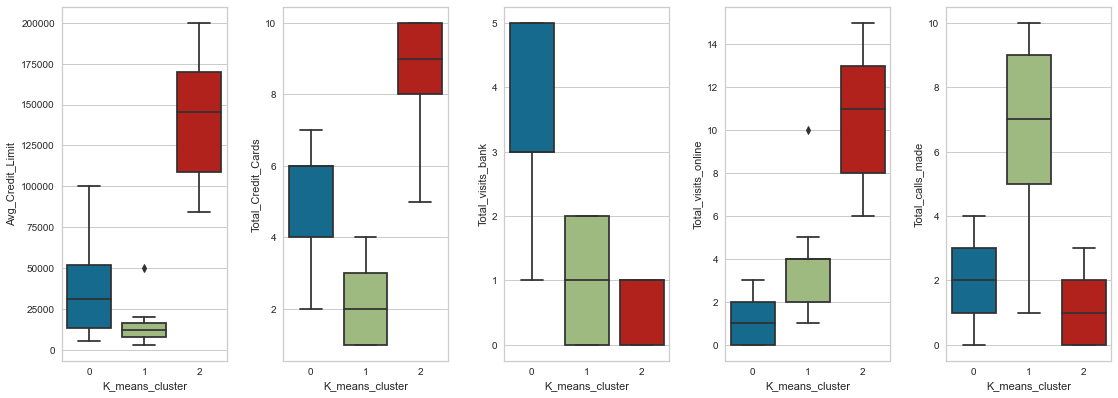

In [31]:
# Create subplots for the different boxplot charts
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
for col in range(5):
    # select the specific feature in con_col
    feature = con_col[col]
    # dsiplay the boxplot
    sns.boxplot(data['K_means_cluster'], data[feature], ax=axes[col], )
fig.tight_layout(pad=2.0)

## 7 Hierarchical Clustering
Now, we are going to use the Hierarchical Clustering method to group the customers

### 7.1 Cophenetic correlation
We are going to use the Cophenetic correlation to identify the appropriate distance metric and linkage method

In [32]:
# start time
start_time = time.time()

# list of distance metrics
distance_metrics = ['euclidean', 'chebyshev', 'mahalanobis', 'cityblock']

# list of linkage methods
linkage_methods = ['single', 'complete', 'average', 'centroid', 'ward', 'weighted']

high_cophenet_corr = 0
high_dm_lm = [0, 0]

# dataframe with Cophenetic correlation
columns = ['Metric', 'Linkage Method', 'Cophenetic correlation']#, 'Cophenetic distance']
cophenet_corr = pd.DataFrame(columns=columns)

# for each metric
for dm in distance_metrics:
    # for each linkage methos
    for lm in linkage_methods:
        # centroid and ward methods require the distance metric to be Euclidean
        if (lm=='centroid' or lm=='ward') and dm!='euclidean' :
            pass
        else:
            # calculate Cophenetic correlation
            Z = linkage(data_scaled_df, metric=dm, method=lm)
            c, coph_dists = cophenet(Z, pdist(data_scaled_df))
            cophenet_corr = cophenet_corr.append(pd.DataFrame([[dm, lm, c]], columns=columns),
                                               ignore_index = True)
print("\n\n--- Execution time %s seconds ---" % (time.time() - start_time))

# sort results by Cophenetic correlation
cophenet_corr.sort_values(by='Cophenetic correlation',ascending=False)





--- Execution time 0.300518274307251 seconds ---


Metric Linkage Method  Cophenetic correlation
2     euclidean        average                0.897708
8     chebyshev        average                0.897416
16    cityblock        average                0.896329
3     euclidean       centroid                0.893939
9     chebyshev       weighted                0.891362
5     euclidean       weighted                0.886175
17    cityblock       weighted                0.882552
15    cityblock       complete                0.873148
1     euclidean       complete                0.859973
7     chebyshev       complete                0.853347
12  mahalanobis        average                0.832699
13  mahalanobis       weighted                0.780599
4     euclidean           ward                0.741516
0     euclidean         single                0.739122
6     chebyshev         single                0.738235
14    cityblock         single                0.725238
10  mahalanobis         single                0.705806
11  mahalanobis       complete                0.666353

- The Cophenetic correlation is maximum with Euclidean distance and average linkage

### 7.2 Dendograms
Now, we are going to use the Dendograms to identify the proper number of clusters.

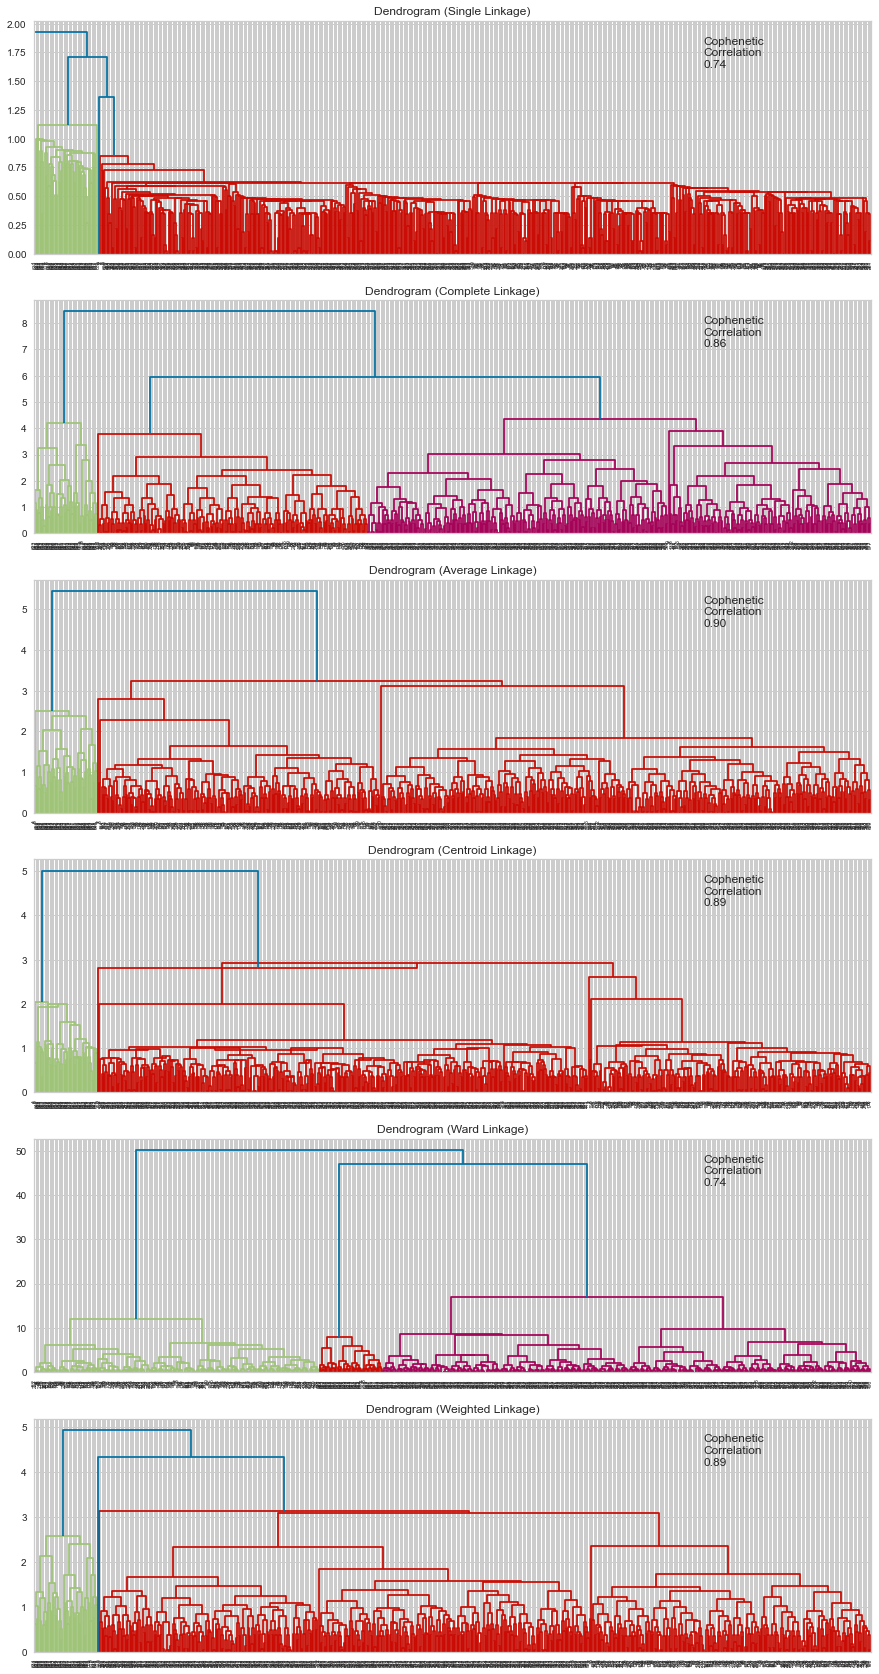

In [33]:
# start time
start_time = time.time()

# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(data_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

In [34]:
print("\n\n--- Execution time %s seconds ---" % (time.time() - start_time))



--- Execution time 133.59463214874268 seconds ---


- Average, centroid and weighted linkage have cophenetic correlation higher than 0.89
- For those 3 metrics the dendograms are similar
- It seems that 3 clusters are the optimal number of groups for those 3 linkage metrics.

### 7.3 Customer profile
- We are going to use Euclidean distance and average linkage because this combination presents the highest cophenetic correlation.
- 3 is an appropriate number for clusters from the dendogram for euclidean distance and average linkage

In [35]:
# start time
start_time = time.time()

HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(data_scaled_df)

print("\n\n--- Execution time %s seconds ---" % (time.time() - start_time))



--- Execution time 0.009972810745239258 seconds ---


**Average values for each feature**

In [36]:
# adding kmeans cluster labels to the original dataframe
data['Hierarchical_cluster'] = HCmodel.labels_
# create cluster profile
cluster_profile_hie = data.groupby('Hierarchical_cluster').mean()
# number of rows in each cluster
cluster_profile_hie['Count'] = (data.groupby('Hierarchical_cluster')['Avg_Credit_Limit'].count().values)

In [37]:
# let's display cluster profiles
cluster_profile_hie.style.highlight_max(color="lightgreen", axis=0)

**Box plots for each feature**

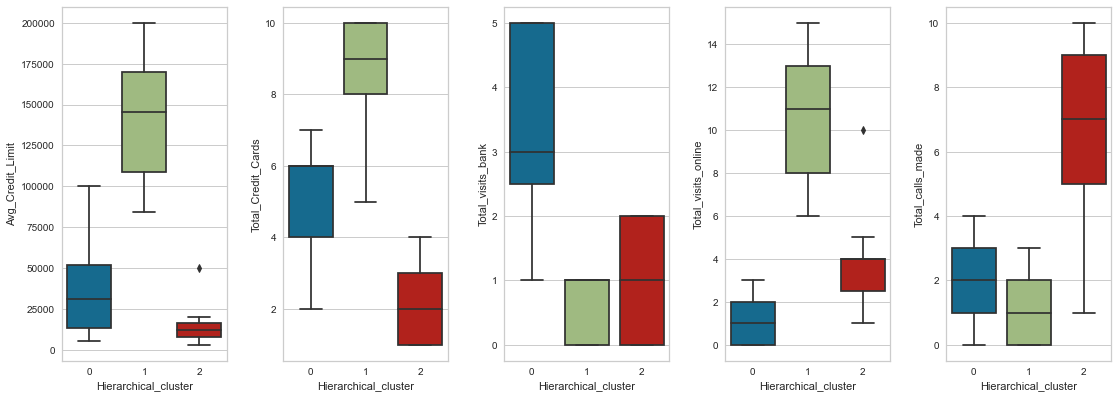

In [38]:
# Create subplots for the different boxplot charts
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
for col in range(5):
    # select the specific feature in con_col
    feature = con_col[col]
    # dsiplay the boxplot
    sns.boxplot(data['Hierarchical_cluster'], data[feature], ax=axes[col], )
fig.tight_layout(pad=2.0)

## 8  K-means and Hierarchical Clustering comparison
Now, we are going to compare both techniques and the clusters found in both of them

### 8.1 Execution time comparison and number of clusters
- **Which clustering technique took less time for execution?**
    - Fit the data is very fast in those techniques. Although, Hierarchical clustering is slightly faster than K-means ( Execution time 0.0065 seconds for Hierarchical clustering vs Execution time 0.0156 seconds for K-means)
    - However, the time to identify the optimal number of clusters is much higher in Hierarchical clustering, the highest execution time was to plot the Dendograms (133 seconds) while the Elbow curve and Silhouette scores took less than 1 second

- **Which clustering technique gave you more distinct clusters, or are they the same?**
    - 3 clusters was the optimal number for both techniques

### 8.2 Cluster comparison
Now, we are going to compare the clusters found in each technique

In [39]:
# Kmeans clustering
cluster_profile_kmeans.style.highlight_max(color="lightgreen", axis=0)

In [40]:
# Hierarchical clustering
cluster_profile_hie.style.highlight_max(color="lightgreen", axis=0)

Both techniques determine almost the same clusters. 

In [41]:
kmeans_clusters = data['K_means_cluster'].unique()
hie_clusters = data['Hierarchical_cluster'].unique()
for kmeans_cluster in kmeans_clusters:
    for hierachical_cluster in hie_clusters:
        ix = (data['K_means_cluster']==kmeans_cluster) & (data['Hierarchical_cluster']==hierachical_cluster)
        if sum(ix)>0:
            print(f'K_means cluster: {kmeans_cluster}, Hierarchical cluster: {hierachical_cluster}, Count: {sum(ix)}')
        

K_means cluster: 0, Hierarchical cluster: 0, Count: 386
K_means cluster: 1, Hierarchical cluster: 0, Count: 1
K_means cluster: 1, Hierarchical cluster: 2, Count: 223
K_means cluster: 2, Hierarchical cluster: 1, Count: 50


- Kmeans cluster 0 corresponds to Hierarchical cluster 0
- Kmeans cluster 1 corresponds to Hierarchical cluster 2
- Kmeans cluster 2 corresponds to Hierarchical cluster 1
- The only difference is 1 customer assigned in Kmeans cluster 1 and Hierarchical cluster 0. Let's investigate the characteristics of this customer

In [42]:
# customer in kmeans cluster 1 and hierarchical cluster 0
ix = (data['K_means_cluster']==1) & (data['Hierarchical_cluster']==0)
data[ix]

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
313              7000                   4                  2   

     Total_visits_online  Total_calls_made  K_means_cluster  \
313                    2                 4                1   

     Hierarchical_cluster  
313                     0

This customer seems more similar to Hierarchical cluster 2 than cluster 0. Therefore, Kmeans clustering performed better clustering for this specific customer

### 8.3 Insights about different customers
Now, we are going to plot the different characteristics of the customers

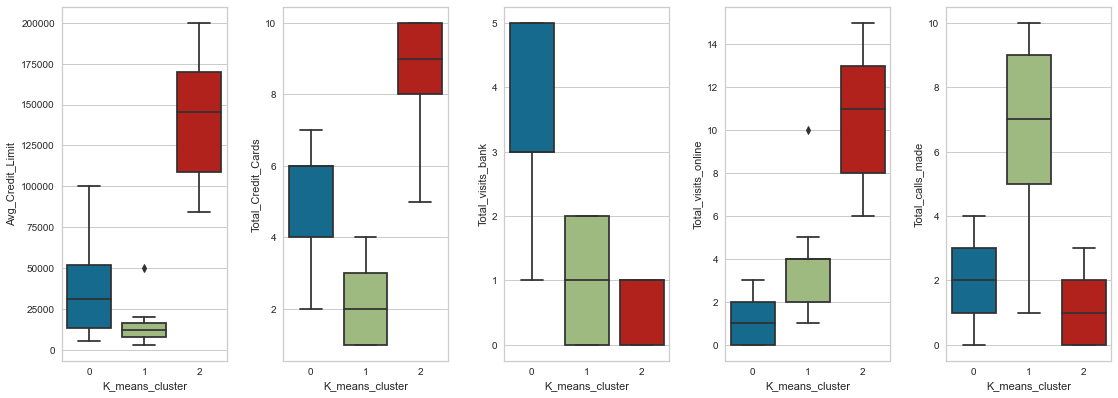

In [43]:
# Create subplots for the different boxplot charts
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
for col in range(5):
    # select the specific feature in con_col
    feature = con_col[col]
    # dsiplay the boxplot
    sns.boxplot(data['K_means_cluster'], data[feature], ax=axes[col], )
fig.tight_layout(pad=2.0)

There are 3 different groups of customers with the following characteristics:
- Group Low Average Credit Limit and Number of Credit Cards - Medium Interaction with the bank:
    - Low Average Credit Limit (Average: 12174.1)
    - Low Total of Credit Cards (Average: 2.4)
    - Medium number of visits to the bank (Average: 0.9)
    - Medium number of visits online (Average: 3.5)
    - High number of calls made (Average: 6.8)
- Group Medium Average Credit Limit and Number of Credit Cards - High in-person / Low online Interaction with the bank :
    - Medium Average Credit Limit (Average: 33782.4)
    - Medium Total of Credit Cards (Average: 5.5)
    - High number of visits to the bank (Average: 3.5)
    - Low number of visits online (Average: 1)
    - Medium number of calls made (Average: 2)
- Group High Average Credit Limit and Number of Credit Cards - Low in-person / High online Interaction with the bank:
    - High Average Credit Limit (Average: 141040.0)
    - High Total of Credit Cards (Average: 8.7)
    - Low number of visits to the bank (Average: 0.6)
    - High number of visits online (Average: 6.9)
    - Low number of calls made (Average: 1.1)
    

## 9 Actionable Insights & Recommendations
- Both K-means and Hierarchical clustering identified 3 different groups of customers. These segments of customers are:
    - Low Average Credit Limit and Number of Credit Cards - Medium Interaction with the bank
    - Medium Average Credit Limit and Number of Credit Cards - High in-person / Low online Interaction with the bank 
    - High Average Credit Limit and Number of Credit Cards - Low in-person / High online Interaction with the bank
- With these 3 different segments of customers, the bank could create personalized campaigns to target these customers and interactions:
    - Although the first segment have low average credit limit and number of credit cards. They like to interact with the bank in in-person, online and calling the bank
    - The second group have medium average credit limit and number of credit cards. This group of customers prefer to have in-person interaction with the bank
    - The third group have high average credit limit and number of credit cards. They rely mainly in online interaction.
- The bank should improve the online interaction and customer service becausecthat would improve the perception of the customers with high credit limit
- The bank should create campaigns for users with low and medium credit limit to use more online services. In-person interactions are more expensive to on-line services, and the bank could reduce cost of services for users with low and medium credit limit